In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
from models import GNNClassifier
import torch
import numpy as np
import util
import scipy
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from sklearn.metrics import accuracy_score
from IPython.display import Image


random_state = 1
batch_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_state)
# torch.cuda.manual_seed(random_state)
np.random.seed(random_state)

path = os.path.join('./', 'data', 'TU')
dataset = TUDataset(path, name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)



def train(model, optimizer, dataloader, device):
    model.train()

    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(data)
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()
        
    return total_loss / len(train_dataset)

def test(model, dataloader, device):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in dataloader:

            data = data.to(device)
            pred = model.predict(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.extend(pred)
            labels.extend(label)
    total_acc = accuracy_score(predictions, labels)
    return total_acc
 

width = [10, 100, 1000]
heatmap1 = []
for w in width:
    print('----------------------- Width: {} -----------------------'.format(w))
    model_config = {}
    model_config["input_dim"] = 7
    model_config["hidden_dim"] = w
    model_config["output_dim"] = w
    model_config["n_class"] = 2
    model_config["c_u"] = 1
    #model_config["c_sigma"] = 2
    model_config["c_sigma"] = 1
    model_config["num_layers"] = 2
    learning_rate = 0.001
    epochs = 25
    gap = 25

    model = GNNClassifier(model_config)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = model.to(device)    
    for epoch in range(1, epochs + 1):
        if epoch == 1 or epoch % gap == 0:
            param = list(model.parameters())
            w2 = param[2]
            heatmap1.append(w2.detach().numpy().copy())
        
        train_loss = train(model, optimizer, train_dataloader, device)
        train_acc = test(model, train_dataloader, device)
        test_acc = test(model, test_dataloader, device)
        print('Epoch: {:03d}, train_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch, train_loss, train_acc, test_acc))

    break
# plot heatmap
def heatmap_func(i):
    sn.heatmap(heatmap1[i], cbar=False)




/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


----------------------- Width: 10 -----------------------
Epoch: 001, train_loss: 0.6116, train_acc: 0.6706, test_acc: 0.6111
Epoch: 002, train_loss: 0.5643, train_acc: 0.6706, test_acc: 0.6111
Epoch: 003, train_loss: 0.5853, train_acc: 0.6706, test_acc: 0.6111
Epoch: 004, train_loss: 0.5615, train_acc: 0.6706, test_acc: 0.6111
Epoch: 005, train_loss: 0.5659, train_acc: 0.6706, test_acc: 0.6111
Epoch: 006, train_loss: 0.5528, train_acc: 0.6706, test_acc: 0.6111
Epoch: 007, train_loss: 0.5566, train_acc: 0.6706, test_acc: 0.6111
Epoch: 008, train_loss: 0.5420, train_acc: 0.6706, test_acc: 0.6111
Epoch: 009, train_loss: 0.5447, train_acc: 0.6706, test_acc: 0.6111
Epoch: 010, train_loss: 0.5450, train_acc: 0.6765, test_acc: 0.6111
Epoch: 011, train_loss: 0.5189, train_acc: 0.6765, test_acc: 0.6111
Epoch: 012, train_loss: 0.5140, train_acc: 0.6765, test_acc: 0.6111
Epoch: 013, train_loss: 0.5348, train_acc: 0.6765, test_acc: 0.6111
Epoch: 014, train_loss: 0.5352, train_acc: 0.6765, test_ac

<IPython.core.display.Javascript object>


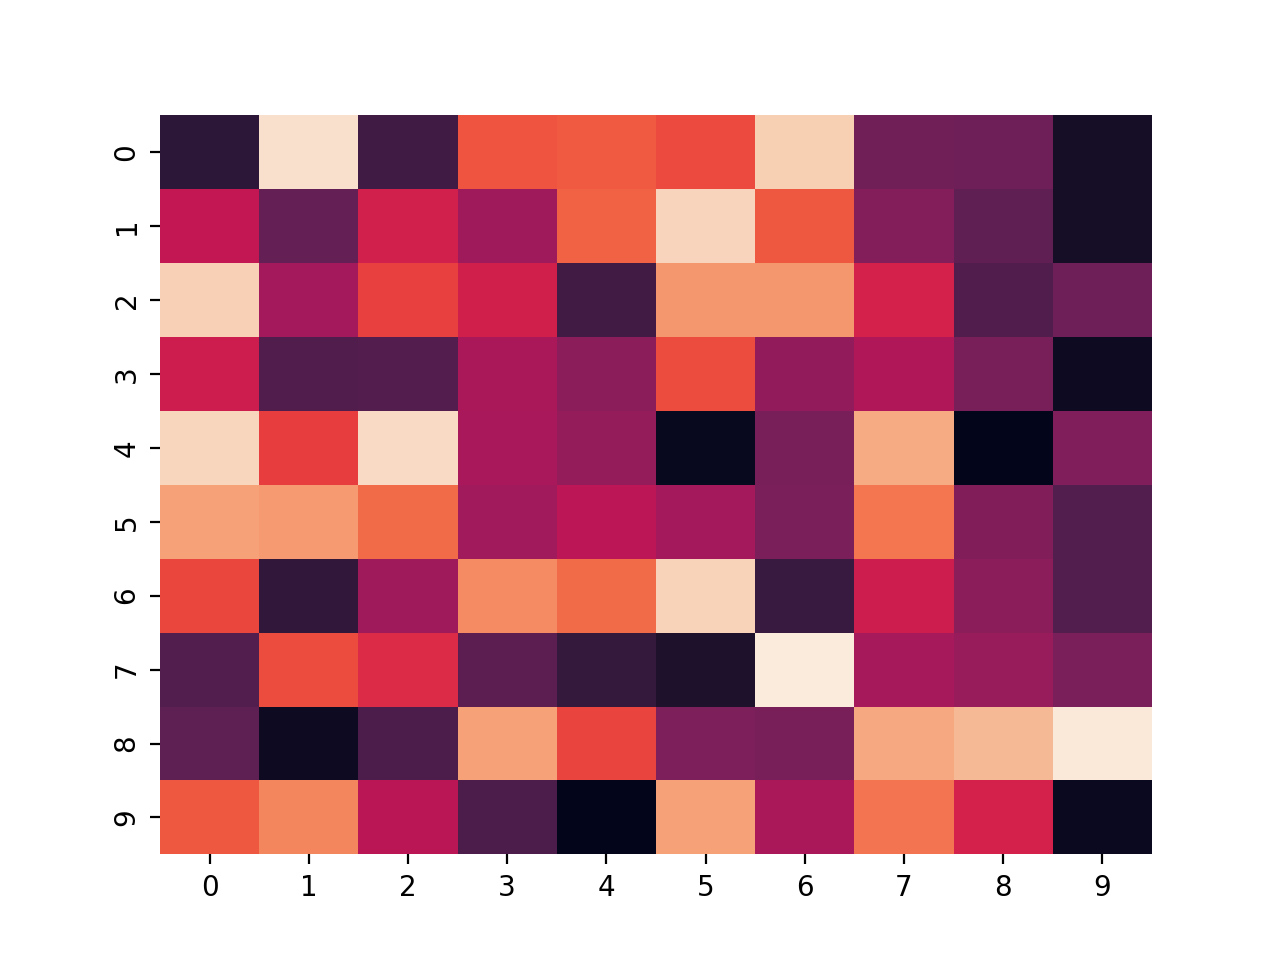

IndexError: list index out of range

In [3]:
fig = plt.figure()
anim = FuncAnimation(fig = fig, func = heatmap_func, frames = int(epochs/gap)+1, interval = 1000, blit = False)
plt.show()
anim.save('./output/lazy_training_width_{}.gif'.format(10), writer=PillowWriter(fps=int(epochs/gap)+1))